In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from warnings import filterwarnings
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [3]:
x_train = []
y_train = []
image_size = 256

folderPath = os.path.join('drive/MyDrive/x-ray/normal')
for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    x_train.append(img)
    y_train.append(0)
    # if len(y_train) == 1000:
    #     break

folderPath = os.path.join('drive/MyDrive/x-ray/bad')
for j in os.listdir(folderPath):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    x_train.append(img)
    y_train.append(1)
    # if len(y_train) == 2000:
    #     break


x_train = np.array(x_train)
y_train = np.array(y_train)

In [4]:
x_train, y_train = shuffle(x_train,y_train, random_state=127)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,
                                      test_size=0.1,random_state=101)

In [6]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [7]:
effnet = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [8]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(1,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [9]:
# model.summary()

In [10]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer = 'Adam', metrics= ['accuracy'])

In [11]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("drive/MyDrive/x-ray/effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [12]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs = 16, verbose=1, batch_size=32,
                   callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/16
236/236 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.9578 
Epoch 1: val_accuracy improved from -inf to 0.97378, saving model to drive/MyDrive/x-ray/effnet.keras
236/236 [==============================] - 2922s 12s/step - loss: 0.1144 - accuracy: 0.9578 - val_loss: 0.0997 - val_accuracy: 0.9738 - lr: 0.0010
Epoch 2/16
236/236 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9796 
Epoch 2: val_accuracy improved from 0.97378 to 0.98212, saving model to drive/MyDrive/x-ray/effnet.keras
236/236 [==============================] - 2811s 12s/step - loss: 0.0579 - accuracy: 0.9796 - val_loss: 0.0793 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 3/16
236/236 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9848 
Epoch 3: val_accuracy did not improve from 0.98212
236/236 [==============================] - 2857s 12s/step - loss: 0.0434 - accuracy: 0.9848 - val_loss: 0.0891 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 4/16

KeyboardInterrupt: 

In [ ]:
model.save("drive/MyDrive/x-ray/effnet_last.keras")

In [13]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

NameError: name 'history' is not defined

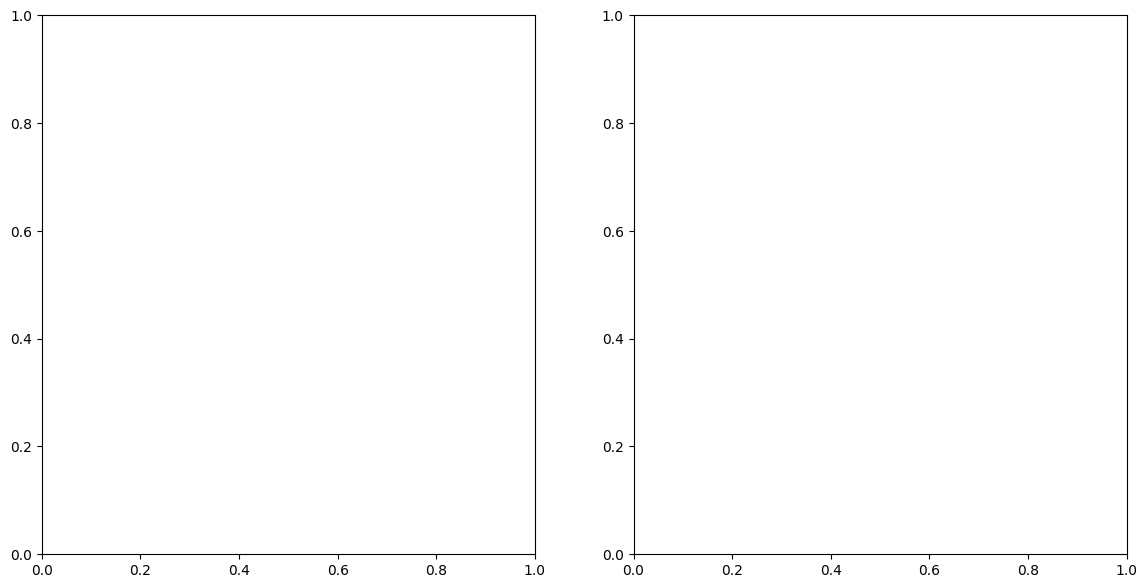

In [14]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

К большому сожалению графики поломались из-за того, что я принудительно остановил обучение.

In [18]:
pred = model.predict(x_test)

30/30 [==============================] - 86s 3s/step


In [23]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       421
           1       0.99      0.99      0.99       511

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932

